# Audiogram Generation
Notebook to train a KDE model on openly available pure-tone audiometric (PTA) data (NHANES). The Resultant KDE model is saved and can be loaded back in to be sampled from. Sampling from the model generates new audiogram curves for both the right and left ears. 

The model preserves the relationships within columns - i.e., how hearing level at a given frequency changes as a function of individuals - as well as the relationships across columns - i.e., how hearing level for a given individual changes across frequency and ears.

We expect to observe similar levels of hearing loss across ears (generally) and that the curve characteristics to be clinically feasible.

N.B., This notebook does not evaluate the model. This notebook simple trains the model and provides *some* exemplar synthetic audiograms and visualisations.  
For a more considered evaluation, look at `nhanes_generator_eval.ipynb`

## Import modules, init notebook settings and define functions

In [ ]:
# import modules
import os
import warnings
import pickle

import pandas as pd
import numpy as np


# Needed for plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Needed for generating data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [3]:
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Change dir to NHANES data
os.chdir('../data')

# Set plotting params
sns.set_theme(rc={"figure.figsize":(15 , 9 )})
sns.set_theme(font_scale=1.5, style="whitegrid")

In [ ]:
def wide_pta_to_long_with_ear(nhanes_pta):
    """Process Pure Tone Audiometry (PTA) data from NHANES dataset with
    wide format to long format with ear codes.

    Args:
        nhanes_pta (DataFrame): DataFrame containing PTA data.

    Returns:
        DataFrame: Processed PTA data DataFrame with columns: 'Hearing Threshold (dB HL)', 'Ear', 'Frequency (Hz)'.
    """

    # Create an empty Pandas DataFrame for storing processed PTA data
    ear_nhanes_pta = pd.DataFrame()

    # Iterate over columns in the original dataset (nhanes_pta)
    for i in nhanes_pta.columns:
        # Determine whether the ear is Right or Left based on column names
        if i.endswith('Right'):
            ear = 'Right'
        elif i.endswith('Left'):
            ear = 'Left'
        else:
            # Skip columns that do not represent Right or Left ear data
            continue

        # Extract the frequency information from the column name
        for j in range(9):
            if i.split(' ')[0][0] == str(j):
                if j == 0:
                    frequency = 500
                else:
                    frequency = j * 1000

        # Extract hearing threshold values for the specific ear and frequency
        pta_values = nhanes_pta[i].to_frame()
        ear_nhanes_pta_i = pta_values.copy()
        ear_nhanes_pta_i.columns = ['Hearing Threshold (dB HL)']
        ear_nhanes_pta_i['Ear'] = np.full((nhanes_pta.shape[0], 1), ear)
        ear_nhanes_pta_i['Frequency (Hz)'] = np.full((nhanes_pta.shape[0], 1), frequency)
        ear_nhanes_pta_i['SEQN'] = nhanes_pta.index

        # Append the processed data to the ear_nhanes_pta DataFrame
        if ear_nhanes_pta.empty:
            ear_nhanes_pta = ear_nhanes_pta_i
        else:
            # Concatenate DataFrames based on frequency, prioritizing 500 Hz data
            if frequency == 500:
                ear_nhanes_pta = pd.concat([ear_nhanes_pta_i, ear_nhanes_pta], axis=0)
            else:
                ear_nhanes_pta = pd.concat([ear_nhanes_pta, ear_nhanes_pta_i], axis=0)

    # Replace infinite values with NaN and reset the index of the resulting DataFrame
    ear_nhanes_pta.replace([np.inf, -np.inf], np.nan, inplace=True)
    ear_nhanes_pta.reset_index(inplace=True, drop=True)

    # Remove rows corresponding to 3000 and 6000 Hz frequencies
    ear_nhanes_pta = ear_nhanes_pta[~ear_nhanes_pta['Frequency (Hz)'].isin([3000, 6000])]

    return ear_nhanes_pta

def process_demo_pta_data(nhanes_demo_pta_df, ordered_nhanes_pta):
    """Process Pure Tone Audiometry (PTA) data from NHANES demographic dataset.

    Args:
        nhanes_demo_pta_df (DataFrame): DataFrame containing demographic data with PTA information.
        ordered_nhanes_pta (DataFrame): DataFrame containing ordered PTA data.

    Returns:
        DataFrame: Processed PTA data DataFrame with columns: 'SEQN', 'Hearing Threshold (dB HL)', 'Frequency (Hz)',
                   'Ear', 'Gender', 'Age (years)', 'Race/ethnicity'.
    """

    # Create an empty Pandas DataFrame for storing processed PTA data
    nhanes_demo_pta_long_df = pd.DataFrame()

    # Iterate over columns in the ordered PTA dataset
    for i in ordered_nhanes_pta.columns:
        # Extract frequency and ear information from the column name
        for j in range(9):
            if i.split(' ')[0][0] == str(j):
                if j == 0:
                    frequency = 500
                else:
                    frequency = j * 1000
            if i.split(' ')[1] == 'Right':
                ear = 'Right'
            elif i.split(' ')[1] == 'Left':
                ear = 'Left'

        # Extract hearing threshold values for the specific ear and frequency
        pta_values = nhanes_demo_pta_df[i].to_frame()
        nhanes_demo_pta_long_i = nhanes_demo_pta_df['SEQN'].to_frame()
        nhanes_demo_pta_long_i['Hearing Threshold (dB HL)'] = pta_values.copy()
        nhanes_demo_pta_long_i['Frequency (Hz)'] = np.full((nhanes_demo_pta_df.shape[0], 1), frequency)
        nhanes_demo_pta_long_i['Ear'] = np.full((nhanes_demo_pta_df.shape[0], 1), ear)
        nhanes_demo_pta_long_i['Gender'] = nhanes_demo_pta_df['Gender']
        nhanes_demo_pta_long_i['Age (years)'] = nhanes_demo_pta_df['Age (years)']
        nhanes_demo_pta_long_i['Race/ethnicity'] = nhanes_demo_pta_df['Race/ethnicity']

        # Append the processed data to the nhanes_demo_pta_long_df DataFrame
        if nhanes_demo_pta_long_df.empty:
            nhanes_demo_pta_long_df = nhanes_demo_pta_long_i
        else:
            # Concatenate DataFrames based on frequency, prioritizing 500 Hz data
            if frequency == 500:
                nhanes_demo_pta_long_df = pd.concat([nhanes_demo_pta_long_i, nhanes_demo_pta_long_df], axis=0)
            else:
                nhanes_demo_pta_long_df = pd.concat([nhanes_demo_pta_long_df, nhanes_demo_pta_long_i], axis=0)

    # Replace infinite values with NaN and reset the index of the resulting DataFrame
    nhanes_demo_pta_long_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    nhanes_demo_pta_long_df.reset_index(inplace=True, drop=True)

    # Remove rows corresponding to 3000 and 6000 Hz frequencies
    nhanes_demo_pta_long_df = nhanes_demo_pta_long_df[~nhanes_demo_pta_long_df['Frequency (Hz)'].isin([3000, 6000])]

    return nhanes_demo_pta_long_df

def get_hearing_loss_info_and_code(pta_data):
    """
    Analyze Pure Tone Audiometry (PTA) data to identify individuals with hearing loss.

    This function takes PTA data as input, identifies individuals with a hearing level
    greater than 25 dB HL as having hearing loss, and adds a corresponding code to the dataset.

    Args:
        pta_data (DataFrame): A pandas DataFrame containing PTA data for individuals.

    Returns:
        tuple: A tuple containing the modified DataFrame with a new 'Hearing Loss' column
               and the number of individuals identified with hearing loss.
    """
    # Copy the input DataFrame to avoid modifying the original data
    pta_data_copy = pta_data.copy()

    # Identify hearing loss (True for hearing level > 25 dB HL)
    pta_hearing_loss = pta_data_copy > 25

    # Initialize counters and index list for individuals with hearing loss
    n_people_with_hl = 0
    idx_of_hl = []

    # Iterate through the DataFrame to count individuals with hearing loss
    for _, row in pta_hearing_loss.iterrows():
        if row.sum() > 0:  # If any value in row indicates hearing loss
            n_people_with_hl += 1
            idx_of_hl.append(1)
        else:
            idx_of_hl.append(0)

    # Add the hearing loss code to the original DataFrame
    pta_data_copy['Hearing Loss'] = idx_of_hl

    return pta_data_copy, n_people_with_hl

## Load in original PTA data

In [5]:
# load in data
nhanes_demo_pta_HL_df = pd.read_csv('nhanes_1999to2020_demo_pta_hearingLoss.csv')

# drop nans
nhanes_demo_pta_HL_dropNa_df = nhanes_demo_pta_HL_df.dropna()

# get just pta data
nhanes_pta_dropNa_df = nhanes_demo_pta_HL_dropNa_df.iloc[:, 1:11]

# create long dataset
nhanes_demo_pta_HL_dropNa_long_df = process_demo_pta_data(nhanes_demo_pta_HL_dropNa_df, nhanes_pta_dropNa_df)

In [6]:
nhanes_demo_pta_HL_df

,SEQN,0.5kHz Right,0.5kHz Left,1kHz Right,1kHz Left,2kHz Right,2kHz Left,4kHz Right,4kHz Left,8kHz Right,8kHz Left,Gender,Age (years),Race/ethnicity,Hearing Loss
0,10.0,10.0,10.0,5.0,5.0,10.0,20.0,15.0,10.0,10.0,15.0,Male,43.0,Non-Hispanic Black,0
1,15.0,0.0,0.0,-5.0,10.0,-5.0,5.0,-5.0,5.0,10.0,5.0,Female,38.0,Non-Hispanic White,0
2,24.0,10.0,10.0,15.0,15.0,15.0,20.0,20.0,25.0,25.0,15.0,Female,53.0,Non-Hispanic White,0
3,45.0,5.0,0.0,0.0,-5.0,0.0,-5.0,5.0,10.0,10.0,0.0,Female,33.0,Mexican American,0
4,56.0,5.0,10.0,20.0,20.0,35.0,40.0,20.0,30.0,10.0,15.0,Male,21.0,Non-Hispanic White,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29709,124797.0,NaN,NaN,5.0,0.0,5.0,-5.0,0.0,5.0,0.0,10.0,Male,9.0,Mexican American,0
29710,124799.0,25.0,20.0,30.0,40.0,40.0,45.0,55.0,60.0,NaN,NaN,Female,80.0,Non-Hispanic White,1
29711,124811.0,30.0,35.0,20.0,30.0,5.0,15.0,15.0,25.0,45.0,60.0,Male,76.0,Non-Hispanic White,1
29712,124820.0,NaN,NaN,5.0,5.0,5.0,10.0,0.0,10.0,30.0,15.0,Female,7.0,Non-Hispanic White,1


In [64]:
print(f'When considering hearing loss in the original NHANES dataset {nhanes_demo_pta_HL_df.iloc[:, -1].sum()} individuals have hearing loss ({(nhanes_demo_pta_HL_df.iloc[:, -1].sum()/nhanes_demo_pta_HL_df.shape[0])*100:.2f}%).')

When considering hearing loss in the original NHANES dataset 11607 individuals have hearing loss (39.06%).


## Train KDE model - PTA only

In [27]:
# prepare pta data for generation
X = nhanes_pta_dropNa_df.to_numpy()

# Set random seed for reproducibility
np.random.seed(26)

# Fit a kernel density model using GridSearchCV to determine the best parameter for bandwidth
bandwidth_params = {'bandwidth': np.arange(0.01,1,0.05)}
grid_search = GridSearchCV(KernelDensity(), bandwidth_params)
grid_search.fit(X)
kde = grid_search.best_estimator_



In [28]:
# Save the model to a file
with open('../models/kde_nhanes1999_2020_randSeed26_model.pkl', 'wb') as f:
    pickle.dump(kde, f)

In [5]:
# Load in pre-trained KDE model
kde = pickle.load(open('../models/kde_nhanes1999_2020_randSeed26_model.pkl', 'rb'))

/Users/liambarrett/miniconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KernelDensity from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
# Generate 100000 new audiograms
new_audiograms_100000_floating = kde.sample(100000, random_state=26)
new_audiograms_100000_multiple5 = np.round((new_audiograms_100000_floating/5))*5

# convert back to dataframe set-up
new_audiogram_100000_df = pd.DataFrame(new_audiograms_100000_multiple5)
new_audiogram_100000_df.columns = nhanes_pta_dropNa_df.columns

# create longer df with ear codes and SEQN
new_audiogram_100000_ear_df = wide_pta_to_long_with_ear(new_audiogram_100000_df)

In [10]:
new_audiogram_100000_df

,0.5kHz Right,0.5kHz Left,1kHz Right,1kHz Left,2kHz Right,2kHz Left,4kHz Right,4kHz Left,8kHz Right,8kHz Left
0,5.0,-5.0,-0.0,5.0,5.0,10.0,15.0,20.0,0.0,5.0
1,-5.0,5.0,-5.0,5.0,-5.0,5.0,10.0,5.0,-5.0,0.0
2,0.0,10.0,-5.0,15.0,-0.0,-0.0,10.0,15.0,25.0,15.0
3,20.0,15.0,25.0,5.0,15.0,10.0,10.0,5.0,15.0,15.0
4,5.0,10.0,5.0,0.0,-0.0,0.0,10.0,15.0,15.0,20.0
...,...,...,...,...,...,...,...,...,...,...
99995,5.0,0.0,5.0,10.0,5.0,10.0,0.0,-0.0,5.0,-0.0
99996,5.0,5.0,0.0,-0.0,0.0,-0.0,0.0,5.0,15.0,0.0
99997,10.0,10.0,0.0,0.0,5.0,-0.0,5.0,-5.0,5.0,30.0
99998,15.0,15.0,10.0,10.0,5.0,-0.0,5.0,5.0,10.0,5.0


In [14]:
# create left ear only df
# Create a list of column names with 'Left' suffix
left_columns = [col for col in new_audiogram_100000_df.columns if col.endswith('Left')]

# Create a new DataFrame with only the 'Left' columns
left_df = new_audiogram_100000_df[left_columns].copy()
left_df

,0.5kHz Left,1kHz Left,2kHz Left,4kHz Left,8kHz Left
0,-5.0,5.0,10.0,20.0,5.0
1,5.0,5.0,5.0,5.0,0.0
2,10.0,15.0,-0.0,15.0,15.0
3,15.0,5.0,10.0,5.0,15.0
4,10.0,0.0,0.0,15.0,20.0
...,...,...,...,...,...
99995,0.0,10.0,10.0,-0.0,-0.0
99996,5.0,-0.0,-0.0,5.0,0.0
99997,10.0,0.0,-0.0,-5.0,30.0
99998,15.0,10.0,-0.0,5.0,5.0


In [15]:
# Generate 1000 new audiograms
new_audiograms_1000_floating = kde.sample(1000, random_state=26)
new_audiograms_1000_multiple5 = np.round((new_audiograms_1000_floating/5))*5

# convert back to dataframe set-up
new_audiogram_1000_df = pd.DataFrame(new_audiograms_1000_multiple5)
new_audiogram_1000_df.columns = nhanes_pta_dropNa_df.columns

# create longer df with ear codes and SEQN
new_audiogram_1000_ear_df = wide_pta_to_long_with_ear(new_audiogram_1000_df)

### Export df's to `.csv`

In [42]:
# NHANES dropna both-ear 1,000 obvs
nhanes_1000_bothEar_df = nhanes_demo_pta_HL_dropNa_df.sample(n=1000, replace=False)
nhanes_1000_bothEar_df.to_csv('../data/nahnes_1000_bothEar.csv', index=False)

# NHANES dropna left-ear 1,000 obvs
## Create a list of column names with 'Right' suffix
right_columns = [col for col in nhanes_demo_pta_HL_dropNa_df.columns if col.endswith('Right')]

## Create a new DataFrame with only the 'Left' columns
nhanes_leftEar_df = nhanes_demo_pta_HL_dropNa_df[[col for col in nhanes_demo_pta_HL_dropNa_df.columns if col not in right_columns]]
nhanes_1000_leftEar_df = nhanes_leftEar_df.sample(n=1000, replace=False)
nhanes_1000_leftEar_df.to_csv('../data/nahnes_1000_leftEar.csv', index=False)

# NHANES dropna both-ear all obvs
nhanes_demo_pta_HL_dropNa_df.to_csv('../data/nahnes_all_bothEar.csv', index=False)

# NHANES dropna left-ear all obvs
nhanes_leftEar_df.to_csv('../data/nahnes_all_leftEar.csv', index=False)

# simulated both-ear 100,000 obvs
#new_audiogram_100000_df.to_csv('../data/sim_pta_100000_bothEar.csv', index=False)

# simulated left-ear 100,000 obvs
# Create a list of column names with 'Left' suffix
left_columns = [col for col in new_audiogram_100000_df.columns if col.endswith('Left')]

# Create a new DataFrame with only the 'Left' columns
new_audiogram_100000_leftEar_df = new_audiogram_100000_df[left_columns].copy()
#new_audiogram_100000_leftEar_df.to_csv('../data/sim_pta_100000_leftEar.csv', index=False)

# Create and insert hearing loss codes for simulated data
new_audiogram_100000_hearingLoss_df, n_people_of_sim_100k_bothEars_with_hl = get_hearing_loss_info_and_code(new_audiogram_100000_df)
print('When considering simulated data - both ears - there are {0} people with hearing loss out of 100k ({1}%)\n'.format(n_people_of_sim_100k_bothEars_with_hl, n_people_of_sim_100k_bothEars_with_hl/1000))
new_audiogram_100000_hearingLoss_df.to_csv('../data/sim_100k_bothEar.csv', index=False)

new_audiogram_100000_leftEar_hearingLoss_df, n_people_of_sim_100k_leftEars_with_hl = get_hearing_loss_info_and_code(new_audiogram_100000_leftEar_df)
print('When considering simulated data - left ear only - there are {0} people with hearing loss out of 100k ({1}%)\n'.format(n_people_of_sim_100k_leftEars_with_hl, n_people_of_sim_100k_leftEars_with_hl/1000))
new_audiogram_100000_leftEar_hearingLoss_df.to_csv('../data/sim_100k_leftEar.csv', index=False)

When considering simulated data - both ears - there are 42018 people with hearing loss out of 100k (42.018%)

When considering simulated data - left ear only - there are 36233 people with hearing loss out of 100k (36.233%)



### Visualise data

#### Example audiogram curves

/Users/liambarrett/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/Users/liambarrett/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.866666666

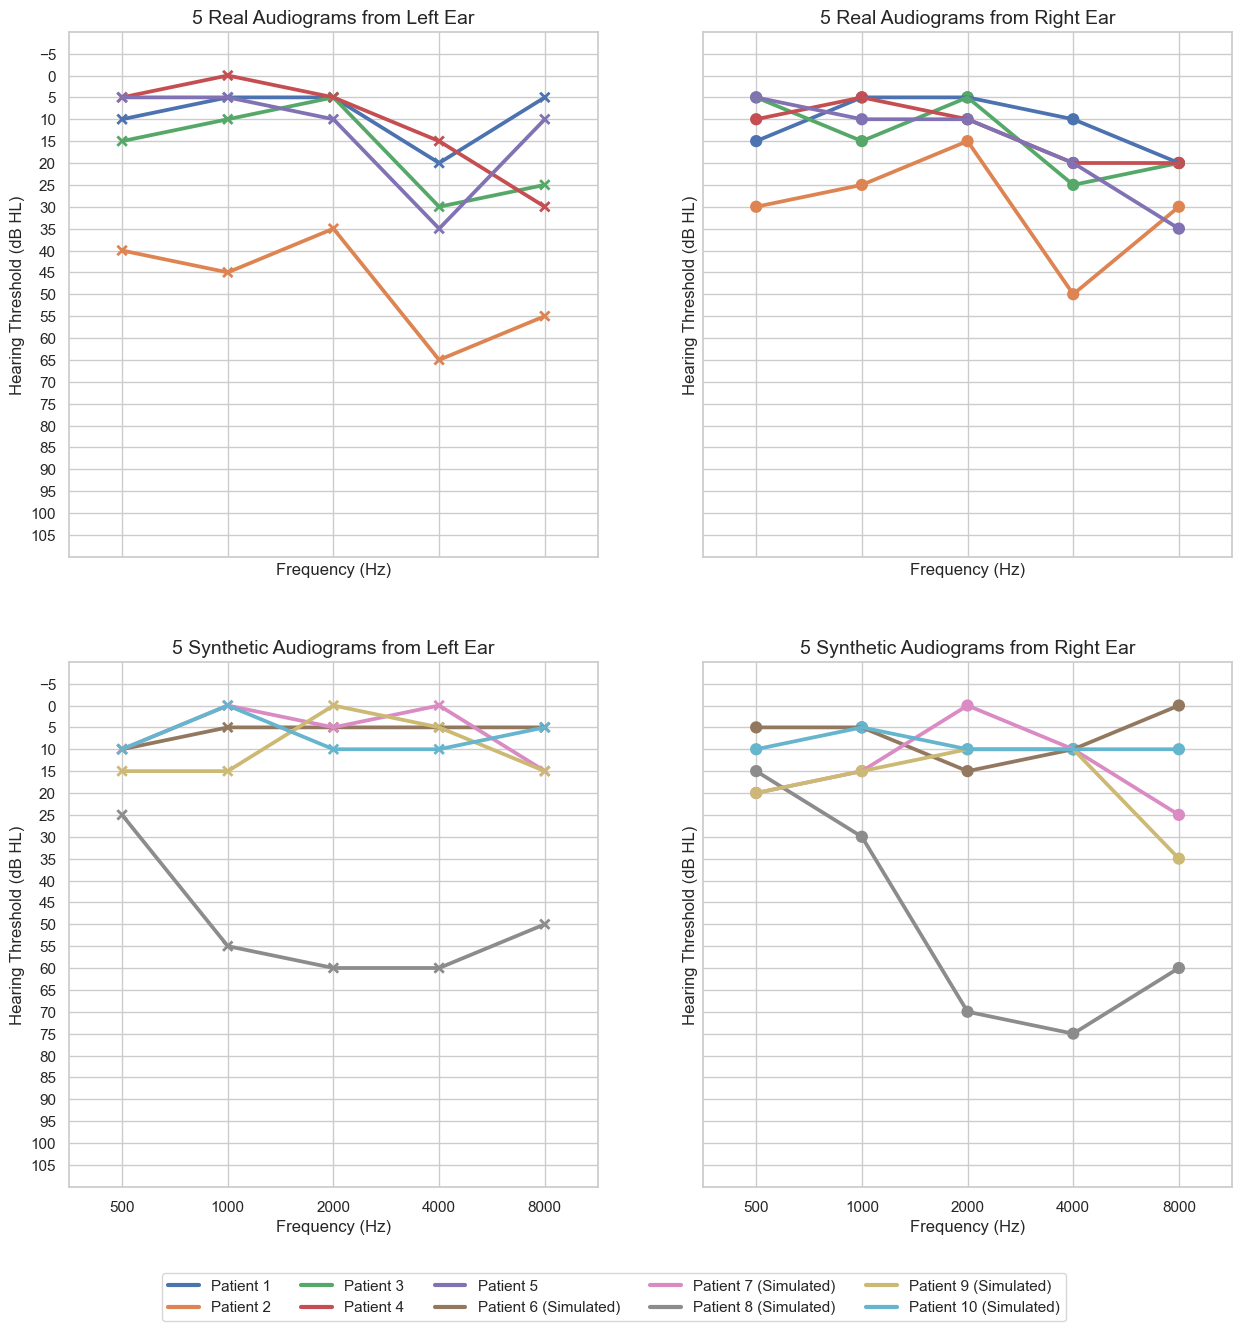

In [ ]:
sns.set_theme(rc={"figure.figsize":(15 , 15 )})
sns.set_theme(style="whitegrid")

# randomly sample n real subjects from NHANES
n_samples = 5
nhanes_sample = nhanes_demo_pta_HL_dropNa_df.SEQN.sample(n=n_samples, random_state=21)

# randomly sample 4 simulated subjects
simulated_sample = new_audiogram_100000_ear_df.SEQN.sample(n=n_samples, random_state=26)

fig, ax = plt.subplots(2,2,
                       sharex=True,
                       sharey=True)

pal = sns.color_palette("deep", n_colors=n_samples*2)
#random.seed(26)
#random.shuffle(pal)

for i in range(n_samples):
    data_i = nhanes_demo_pta_HL_dropNa_long_df[nhanes_demo_pta_HL_dropNa_long_df.SEQN==nhanes_sample.iloc[i]]
    data_i = data_i[data_i.Ear =='Left']
    sns.pointplot(
        data=data_i,
        ax=ax[0, 0],
        x="Frequency (Hz)",
        y="Hearing Threshold (dB HL)",
        color=pal[i],
        markers=["x"],
        linestyles=["-"],
        #markersize=10,
        capsize=.1,
        errorbar=None,
        dodge=True,
        #legend=False
        )
    data_i = nhanes_demo_pta_HL_dropNa_long_df[nhanes_demo_pta_HL_dropNa_long_df.SEQN==nhanes_sample.iloc[i]]
    data_i = data_i[data_i.Ear =='Right']
    sns.pointplot(
        data=data_i,
        ax=ax[0, 1],
        x="Frequency (Hz)",
        y="Hearing Threshold (dB HL)",
        color=pal[i],
        markers=["o"],
        linestyles=["-"],
        #markersize=10,
        capsize=.1,
        errorbar=None,
        dodge=True,
        #legend=False
        )

# now synth data
for i in range(n_samples):
    data_i = new_audiogram_100000_ear_df[new_audiogram_100000_ear_df.SEQN==simulated_sample.iloc[i]]
    data_i = data_i[data_i.Ear =='Left']
    sns.pointplot(
        data=data_i,
        ax=ax[1, 0],
        x="Frequency (Hz)",
        y="Hearing Threshold (dB HL)",
        color=pal[n_samples+i],
        markers=["x"],
        linestyles=["-"],
        #markersize=10,
        capsize=.1,
        errorbar=None,
        dodge=True,
        #legend=False
        )
    data_i = new_audiogram_100000_ear_df[new_audiogram_100000_ear_df.SEQN==simulated_sample.iloc[i]]
    data_i = data_i[data_i.Ear =='Right']
    sns.pointplot(
        data=data_i,
        ax=ax[1, 1],
        x="Frequency (Hz)",
        y="Hearing Threshold (dB HL)",
        color=pal[n_samples+i],
        markers=["o"],
        linestyles=["-"],
        #markersize=10,
        capsize=.1,
        errorbar=None,
        dodge=True,
        #legend=False
        )

plt.yticks(np.arange(-5, 110, 5))
plt.ylim((-10, 110))
for axes_row in ax:
    for subplot_ax in axes_row:
        subplot_ax.grid(visible=True, which='both')
        subplot_ax.invert_yaxis()
ax[0, 0].invert_yaxis()

custom_lines = [Line2D([0], [0], color=pal[0], linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[1], linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[2], linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[3], linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[4], linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[5], linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[6], linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[7], linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[8], linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[9], linestyle='-', lw=3, markersize=10, markeredgewidth=2)]

ax[0, 0].legend(custom_lines,
            ['Patient '+str(x+1) for x in range(n_samples)]+['Patient '+str(x+6)+' (Simulated)' for x in range(n_samples)],
            ncols=5,
            loc='best', bbox_to_anchor=(1.9, -1.35))
ax[0, 0].set_title('5 Real Audiograms from Left Ear', fontdict={'fontsize':14})
ax[0, 1].set_title('5 Real Audiograms from Right Ear', fontdict={'fontsize':14})
ax[1, 0].set_title('5 Synthetic Audiograms from Left Ear', fontdict={'fontsize':14})
ax[1, 1].set_title('5 Synthetic Audiograms from Right Ear', fontdict={'fontsize':14})

plt.savefig('../figures/synth_real_example_audiograms.png', dpi=300,  bbox_inches="tight")


#### Distribution of Hearing levels from NHANES

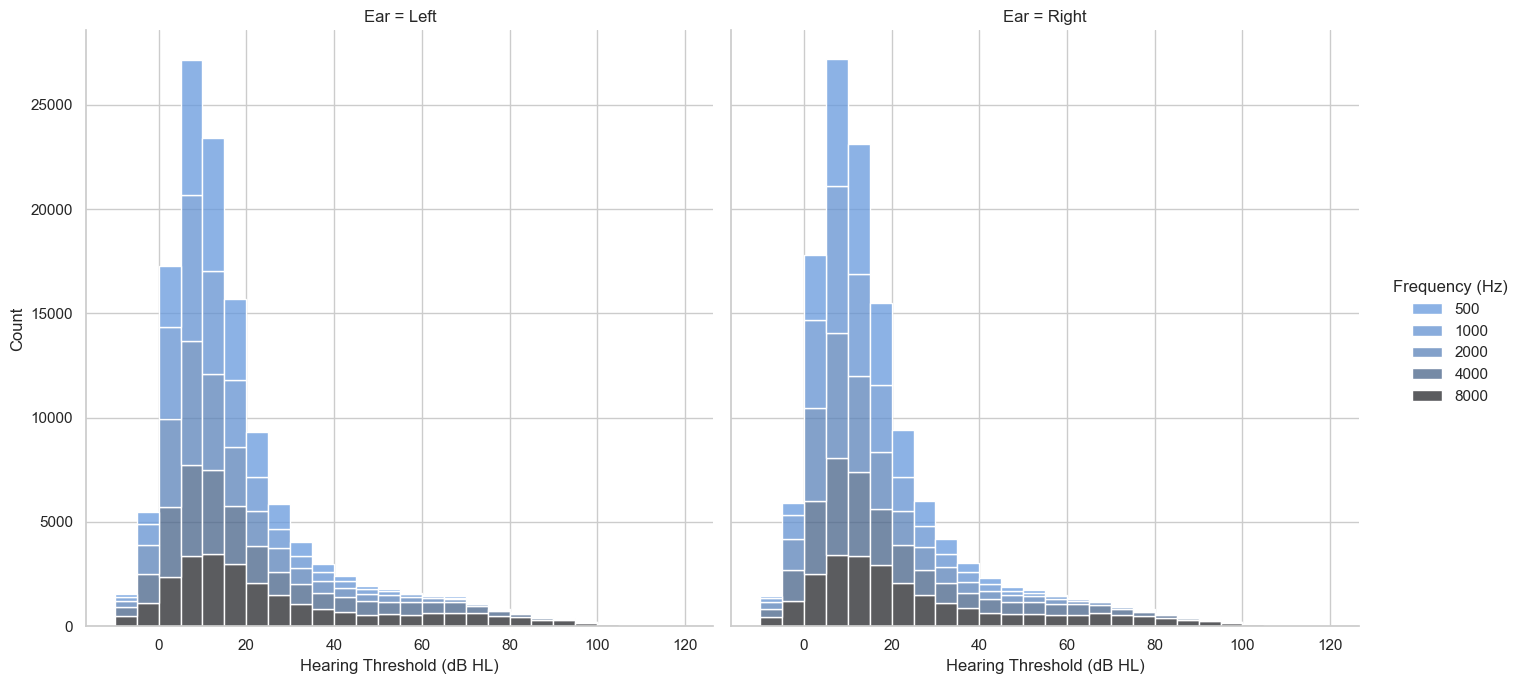

In [114]:
sns.displot(nhanes_demo_pta_HL_dropNa_long_df, x="Hearing Threshold (dB HL)", hue="Frequency (Hz)", col="Ear", multiple="stack",
            height=7, palette=sns.dark_palette("#69d", reverse=True, as_cmap=True),
            binwidth=5)

#### Simulated distribution of audiograms

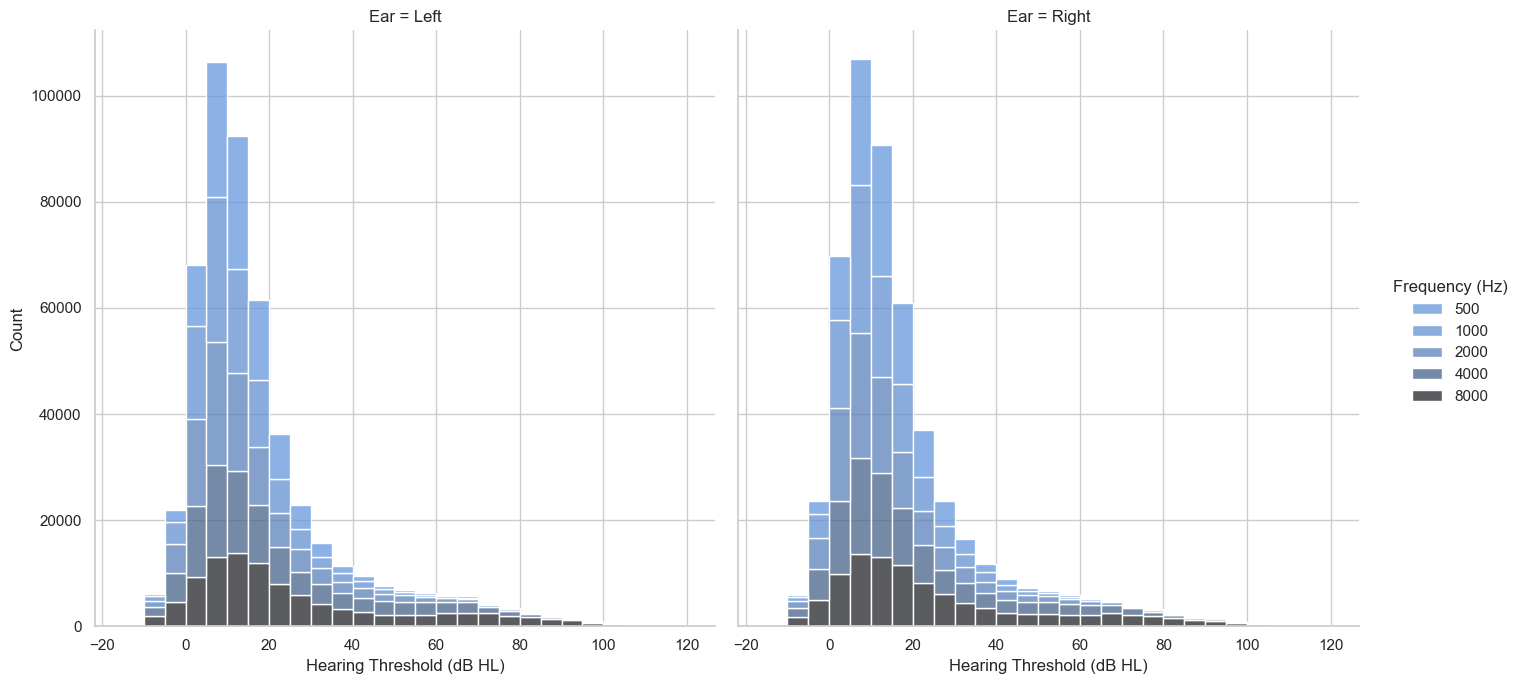

In [117]:
sns.displot(new_audiogram_100000_ear_df, x="Hearing Threshold (dB HL)", hue="Frequency (Hz)", col="Ear", multiple="stack",
            height=7, palette=sns.dark_palette("#69d", reverse=True, as_cmap=True),
            binwidth=5)

### Comparitive descriptives of real and simulated audiograms

In [125]:
# create hearing loss data subset
sim_pta_hearingLoss = new_audiogram_100000_ear_df > 25
sim_pta_hearingLoss_desc = sim_pta_hearingLoss.iloc[:2, :]
for column_i in range(sim_pta_hearingLoss.shape[1]):
    column_i_HL_true = sim_pta_hearingLoss.iloc[:, column_i].sum()
    column_i_HL_false = sim_pta_hearingLoss.shape[0] - column_i_HL_true
    sim_pta_hearingLoss_desc.iloc[:, column_i] = np.array([column_i_HL_true, column_i_HL_false])

n_people_with_HL = 0
idx_of_HL = []
for idx, row in sim_pta_hearingLoss.iterrows():
    if sum(row) > 0:
        n_people_with_HL+=1
        idx_of_HL.append(1)
    else:
        idx_of_HL.append(0)

new_audiogram_HL_df = new_audiogram_100000_ear_df.copy()
new_audiogram_HL_df['Hearing Loss'] = idx_of_HL

In [124]:
sim_pta_hearingLoss_desc

,0.5kHz Right,0.5kHz Left,1kHz Right,1kHz Left,2kHz Right,2kHz Left,4kHz Right,4kHz Left,8kHz Right,8kHz Left
0,7651,7223,8123,7952,12176,13200,22412,24431,31011,31635
1,92349,92777,91877,92048,87824,86800,77588,75569,68989,68365


In [127]:
print(f'Total number of simulated subjects with hearing loss = {n_people_with_HL}\nTotal number of people in NHANES = {new_audiogram_100000_ear_df.shape[0]}\nPercetage of people in NHANES with hearaing loss = {(n_people_with_HL/new_audiogram_HL_df.shape[0])*100}')

Total number of simulated subjects with hearing loss = 41822
Total number of people in NHANES = 100000
Percetage of people in NHANES with hearaing loss = 41.821999999999996


## Train KDE model - PTA and Demographics

### Codify Non-numerical data

In [56]:
nhanes_demo_pta_HL_dropna_df = nhanes_demo_pta_HL_df.dropna()
nhanes_demo_pta_HL_dropna_df

,SEQN,0.5kHz Right,0.5kHz Left,1kHz Right,1kHz Left,2kHz Right,2kHz Left,4kHz Right,4kHz Left,8kHz Right,8kHz Left,Gender,Age (years),Race/ethnicity,Hearing Loss
0,10.0,10.0,10.0,5.0,5.0,10.0,20.0,15.0,10.0,10.0,15.0,Male,43.0,Non-Hispanic Black,0
1,15.0,0.0,0.0,-5.0,10.0,-5.0,5.0,-5.0,5.0,10.0,5.0,Female,38.0,Non-Hispanic White,0
2,24.0,10.0,10.0,15.0,15.0,15.0,20.0,20.0,25.0,25.0,15.0,Female,53.0,Non-Hispanic White,0
3,45.0,5.0,0.0,0.0,-5.0,0.0,-5.0,5.0,10.0,10.0,0.0,Female,33.0,Mexican American,0
4,56.0,5.0,10.0,20.0,20.0,35.0,40.0,20.0,30.0,10.0,15.0,Male,21.0,Non-Hispanic White,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29706,124784.0,45.0,45.0,45.0,50.0,55.0,50.0,50.0,50.0,60.0,80.0,Female,80.0,Non-Hispanic Black,1
29707,124786.0,5.0,0.0,5.0,10.0,5.0,10.0,0.0,0.0,5.0,0.0,Female,18.0,Non-Hispanic White,0
29708,124787.0,5.0,20.0,0.0,10.0,10.0,5.0,0.0,5.0,15.0,5.0,Female,19.0,Non-Hispanic Black,0
29711,124811.0,30.0,35.0,20.0,30.0,5.0,15.0,15.0,25.0,45.0,60.0,Male,76.0,Non-Hispanic White,1


In [61]:
nhanes_demo_pta_HL_dropna_df['Gender'].value_counts()

Gender
Female    12993
Male      12463
Name: count, dtype: int64

In [60]:
nhanes_demo_pta_HL_dropna_df['Race/ethnicity'].value_counts()

Race/ethnicity
Non-Hispanic White                     9751
Non-Hispanic Black                     5997
Mexican American                       4680
Other Race - Including Multi-Racial    2893
Other Hispanic                         2135
Name: count, dtype: int64

In [59]:
(nhanes_demo_pta_HL_dropna_df['Race/ethnicity'].value_counts()/nhanes_demo_pta_HL_dropna_df.shape[0])*100

Race/ethnicity
Non-Hispanic White                     38.305311
Non-Hispanic Black                     23.558297
Mexican American                       18.384664
Other Race - Including Multi-Racial    11.364708
Other Hispanic                          8.387021
Name: count, dtype: float64

In [62]:
# codify the non-numerical values
# make a copy
nhanes_demoNumerical_pta_HL_df = nhanes_demo_pta_HL_dropna_df.copy()

# Gender
nhanes_demoNumerical_pta_HL_df['Gender'] = nhanes_demoNumerical_pta_HL_df['Gender'].map({'Female': 0, 'Male': 1})

# Race/ethnicity
nhanes_demoNumerical_pta_HL_df['Race/ethnicity'] = nhanes_demoNumerical_pta_HL_df['Race/ethnicity'].map({'Non-Hispanic White': 0,
                                                                                                         'Non-Hispanic Black': 1,
                                                                                                         'Mexican American':2,
                                                                                                         'Other Race - Including Multi-Racial':3,
                                                                                                         'Other Hispanic':4})

# drop SEQN and Hearing Loss for numpy array
nhanes_demoNumerical_pta_HL_arr = nhanes_demoNumerical_pta_HL_df.iloc[:, 1:-1].to_numpy()

nhanes_demoNumerical_pta_HL_df

,SEQN,0.5kHz Right,0.5kHz Left,1kHz Right,1kHz Left,2kHz Right,2kHz Left,4kHz Right,4kHz Left,8kHz Right,8kHz Left,Gender,Age (years),Race/ethnicity,Hearing Loss
0,10.0,10.0,10.0,5.0,5.0,10.0,20.0,15.0,10.0,10.0,15.0,1,43.0,1,0
1,15.0,0.0,0.0,-5.0,10.0,-5.0,5.0,-5.0,5.0,10.0,5.0,0,38.0,0,0
2,24.0,10.0,10.0,15.0,15.0,15.0,20.0,20.0,25.0,25.0,15.0,0,53.0,0,0
3,45.0,5.0,0.0,0.0,-5.0,0.0,-5.0,5.0,10.0,10.0,0.0,0,33.0,2,0
4,56.0,5.0,10.0,20.0,20.0,35.0,40.0,20.0,30.0,10.0,15.0,1,21.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29706,124784.0,45.0,45.0,45.0,50.0,55.0,50.0,50.0,50.0,60.0,80.0,0,80.0,1,1
29707,124786.0,5.0,0.0,5.0,10.0,5.0,10.0,0.0,0.0,5.0,0.0,0,18.0,0,0
29708,124787.0,5.0,20.0,0.0,10.0,10.0,5.0,0.0,5.0,15.0,5.0,0,19.0,1,0
29711,124811.0,30.0,35.0,20.0,30.0,5.0,15.0,15.0,25.0,45.0,60.0,1,76.0,0,1


In [63]:
nhanes_demoNumerical_pta_HL_df['Race/ethnicity'].value_counts()

Race/ethnicity
0    9751
1    5997
2    4680
3    2893
4    2135
Name: count, dtype: int64

### Run KDE training

In [23]:
# Set random seed for reproducibility
np.random.seed(26)

# Fit a kernel density model using GridSearchCV to determine the best parameter for bandwidth
bandwidth_params = {'bandwidth': np.arange(0.01,1,0.05)}
grid_search = GridSearchCV(KernelDensity(), bandwidth_params)
grid_search.fit(nhanes_demoNumerical_pta_HL_arr)
kde = grid_search.best_estimator_

In [24]:
# Save the model to a file
with open('../models/kde_nhanes1999_2020_ptaDemo_randSeed26_model.pkl', 'wb') as f:
    pickle.dump(kde, f)

In [25]:
# Load in pre-trained KDE model
kde = pickle.load(open('../models/kde_nhanes1999_2020_ptaDemo_randSeed26_model.pkl', 'rb'))

In [40]:
# Generate 100000 new audiograms
new_audiograms_100000_floating = kde.sample(100000, random_state=26)

# separate out PTA and demographics for tidying
# PTA
new_audiograms_100000_pta_floating = new_audiograms_100000_floating[:, :10]
new_audiograms_100000_multiple5 = np.round((new_audiograms_100000_pta_floating/5))*5

# Gender
new_audiograms_100000_gender_floating = new_audiograms_100000_floating[:, 10]
new_audiograms_100000_gender = np.rint(np.clip(new_audiograms_100000_gender_floating, 0, 1))

# Age
new_audiograms_100000_age_floating = new_audiograms_100000_floating[:, 11]
new_audiograms_100000_age = np.rint(new_audiograms_100000_age_floating)

# Race/ethnicity
new_audiograms_100000_race_floating = new_audiograms_100000_floating[:, -1]
new_audiograms_100000_race = np.rint(np.clip(new_audiograms_100000_race_floating, 0, 4))

# Concat demographics back together
new_audiograms_100000_demo = np.transpose(np.vstack([new_audiograms_100000_gender, new_audiograms_100000_age, new_audiograms_100000_race]))


# convert back to data frame set-up
new_audiogram_100000_df = pd.DataFrame(np.concatenate([new_audiograms_100000_multiple5, new_audiograms_100000_demo], axis=1))
new_audiogram_100000_df.columns = nhanes_demoNumerical_pta_HL_df.iloc[:, 1:-1].columns

new_audiogram_100000_df

,0.5kHz Right,0.5kHz Left,1kHz Right,1kHz Left,2kHz Right,2kHz Left,4kHz Right,4kHz Left,8kHz Right,8kHz Left,Gender,Age (years),Race/ethnicity
0,15.0,15.0,15.0,10.0,5.0,15.0,15.0,10.0,10.0,15.0,1.0,19.0,1.0
1,10.0,5.0,10.0,20.0,15.0,10.0,40.0,30.0,70.0,60.0,1.0,51.0,2.0
2,20.0,10.0,30.0,25.0,35.0,30.0,45.0,50.0,50.0,40.0,0.0,75.0,0.0
3,10.0,10.0,5.0,5.0,10.0,5.0,5.0,5.0,15.0,5.0,0.0,5.0,1.0
4,-0.0,5.0,-0.0,-5.0,-0.0,0.0,0.0,-0.0,0.0,-10.0,0.0,16.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10.0,10.0,10.0,10.0,15.0,5.0,25.0,20.0,25.0,30.0,1.0,33.0,1.0
99996,15.0,0.0,0.0,10.0,20.0,15.0,15.0,5.0,15.0,5.0,0.0,8.0,2.0
99997,20.0,15.0,20.0,20.0,25.0,20.0,10.0,10.0,35.0,5.0,0.0,9.0,4.0
99998,10.0,10.0,5.0,15.0,-0.0,5.0,15.0,15.0,30.0,20.0,0.0,46.0,2.0


In [45]:
new_audiogram_100000_df['Age (years)'].describe()

count    100000.00000
mean         37.05741
std          22.61453
min           3.00000
25%          16.00000
50%          32.00000
75%          56.00000
max          88.00000
Name: Age (years), dtype: float64

In [54]:
(new_audiogram_100000_df['Gender'].value_counts()/new_audiogram_100000_df.shape[0])*100

Gender
0.0    50.338
1.0    49.662
Name: count, dtype: float64

In [53]:
(new_audiogram_100000_df['Race/ethnicity'].value_counts()/new_audiogram_100000_df.shape[0])*100

Race/ethnicity
0.0    34.992
1.0    23.502
2.0    18.405
3.0    12.523
4.0    10.578
Name: count, dtype: float64

### Descriptives of synthesised NHANES PTA data with demographics

In [50]:
_, n_people_of_sim_100k_bothEars_with_hl = get_hearing_loss_info_and_code(new_audiogram_100000_df.iloc[:, :10])

In [51]:
print(f'Total number of simulated subjects with hearing loss = {n_people_of_sim_100k_bothEars_with_hl}\nTotal number of people in NHANES = {new_audiogram_100000_df.shape[0]}\nPercetage of people in NHANES with hearing loss = {(n_people_of_sim_100k_bothEars_with_hl/new_audiogram_100000_df.shape[0])*100}')

Total number of simulated subjects with hearing loss = 41817
Total number of people in NHANES = 100000
Percetage of people in NHANES with hearing loss = 41.817


#### Reduce down to people aged 18 to 30

In [73]:
new_audiogram_1830yrs_df = new_audiogram_100000_df[new_audiogram_100000_df['Age (years)'] >= 18]
new_audiogram_1830yrs_df= new_audiogram_1830yrs_df[new_audiogram_100000_df['Age (years)'] <= 30]
new_audiogram_1830yrs_df['Age (years)'].describe()

/var/folders/4l/_d6zvn5n5c73fxhj1cgbb6g80000gn/T/ipykernel_19914/88844104.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_audiogram_1830yrs_df= new_audiogram_1830yrs_df[new_audiogram_100000_df['Age (years)'] <= 30]


count    19326.000000
mean        22.730208
std          3.936845
min         18.000000
25%         19.000000
50%         22.000000
75%         26.000000
max         30.000000
Name: Age (years), dtype: float64

In [74]:
new_audiogram_1830yrs_df.shape

(19326, 13)

In [75]:
_, n_hl_1830 = get_hearing_loss_info_and_code(new_audiogram_1830yrs_df.iloc[:, :10])

In [77]:
print(f'Total number of simulated subjects between 18-30 years with hearing loss = {n_hl_1830}\nTotal number of people in NHANES = {new_audiogram_1830yrs_df.shape[0]}\nPercetage of people in NHANES with hearing loss = {(n_hl_1830/new_audiogram_1830yrs_df.shape[0])*100}')

Total number of simulated subjects between 18-30 years with hearing loss = 2806
Total number of people in NHANES = 19326
Percetage of people in NHANES with hearing loss = 14.519300424298873


In [78]:
new_audiogram_1830yrs_df.to_csv('../data/synth_nhanes_pta_demo_1830yrs.csv', index=False)